In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import defaultdict
from time import time

In [60]:
def generate_maze(X, Y, objects, probability):
    #Funtion that generates random maze with set of objects that have given probability
    #of appearing. Start (x=0,y=0) and end (x=X,y=Y) points always have to be white (walkable)
        if len(objects) != len(probability):
            print(f'[Error] Objects and probability have different number of items.')
            return None
        elif np.sum(probability) != 1.0:
            print(f'[Error] Sum of probabilities does not equal 1.0.')
            return None
        else:
            maze = np.random.choice(objects,(X,Y),p=probability)
            maze[0,0] = 0
            maze[X-1,Y-1] = 0
            return maze

In [61]:
X, Y = 8, 10
maze = generate_maze(X,Y,[0,1],[0.8,0.2])

In [62]:
allowed_actions = {'D':[1,0],'U':[-1,0],'R':[0,1],'L':[0,-1]}
special_points = {0:1,1:100}

In [63]:
class Maze:
    def __init__(self, maze,specials_points={0:1,1:100}):
        self.maze = maze
        self.special_points = specials_points       #Dict containing points for each of the objects
        self.Y,self.X = [i-1 for i in maze.shape]   #Size of maze -1 because we start from (0,0)
        self.robot_position = (0,0)                 #Current position of robot
        self.steps = []                             #All steps taken by robot
        self.score = 0
        self.allowed_steps = defaultdict(list)      #List of allowed stapes
        self.find_allowed_steps()                   #Construct dict of possible steps along with cost

    def check_move(self, y, x, action):
        y += allowed_actions[action][0]
        x += allowed_actions[action][1]

        if x < 0 or y < 0 or x > self.X or y > self.Y:
            return False
        else:
            return True
    
    def move_value(self, y, x, action):
        y += allowed_actions[action][0]
        x += allowed_actions[action][1]
        return self.special_points[self.maze[y,x]]
    
    def check_game_over(self):
        if self.robot_position == (self.Y,self.X):
            return True
        else:
            return False
    
    def find_allowed_steps(self):
        for y in range(self.Y+1):
            for x in range(self.X+1):
                for action in allowed_actions:
                    if self.check_move(y,x,action):
                        self.allowed_steps[(y,x)].append(action)
    
    def print_allowed_steps(self):
        string_size = 30
        print('|' + '-'*(string_size-1))
        for k, v in self.allowed_steps.items():
            string = f'Position: {k[0]},{k[1]}'
            for action in v:
                string += '\n'
                string += f'|   |- {action} -> Cost: {self.move_value(k[0],k[1],action)}'
            print('|-' + string)
        print('|' + '-'*(string_size-1))
        return self.allowed_steps

    def update_maze(self,action):
        y, x = self.robot_position
        if self.check_move(y, x, action):
            reward = self.move_value(y,x,action)
            self.score += self.move_value(y,x,action)
            y += allowed_actions[action][0]
            x += allowed_actions[action][1]
            self.robot_position = (y,x)
            self.steps.append(action)
            #print(self.score)
        else:
            print('Move imposible.')
        return self.robot_position, reward
    
    def return_results_and_reset(self):
        result_score = self.score
        result_steps = self.steps
        self.score = 0
        self.steps = []
        self.robot_position = (0,0)
        return result_score, result_steps
    
    def return_current_state(self):
        return self.robot_position
    
    def show_maze(self):
        cmap = colors.ListedColormap(['white','red','black','grey','darkred',
                                      'green','yellow','cyan'])
        bounds = [0,1,2,3,4,5,6,7]
        norm = colors.BoundaryNorm(bounds,cmap.N)
        maze_copy = self.maze.copy()
        maze_copy[self.robot_position] = 2
        y, x = (0,0)
        for action in self.steps:
            y += allowed_actions[action][0]
            x += allowed_actions[action][1]
            maze_copy[(y,x)] += 3
        plt.figure()
        im = plt.imshow(maze_copy,interpolation='none', aspect='equal',
                        cmap=cmap,norm=norm)
        ax = plt.gca()
        # Major ticks
        ax.set_xticks(np.arange(0, self.X+1, 1))
        ax.set_yticks(np.arange(0, self.Y+1, 1))
        # # Minor ticks
        ax.set_xticks(np.arange(-.5, self.X+1, 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.Y+1, 1), minor=True)
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
        # Remove minor ticks
        ax.tick_params(which='minor', bottom=False, left=False)

In [64]:
game = Maze(maze,special_points)

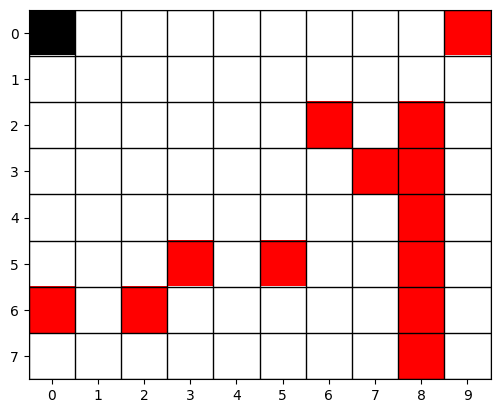

In [65]:
game.show_maze()

In [66]:
steps = game.print_allowed_steps()

|-----------------------------
|-Position: 0,0
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|-Position: 0,1
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,2
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,3
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,4
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,5
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,6
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,7
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,8
|   |- D -> Cost: 1
|   |- R -> Cost: 100
|   |- L -> Cost: 1
|-Position: 0,9
|   |- D -> Cost: 1
|   |- L -> Cost: 1
|-Position: 1,0
|   |- D -> Cost: 1
|   |- U -> Cost: 1
|   |- R -> Cost: 1
|-Position: 1,1
|   |- D -> Cost: 1
|   |- U -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 1,2
|   |- D -> Cost: 1
|   |- U -> Cost: 1
|   |- R -> Cost: 1

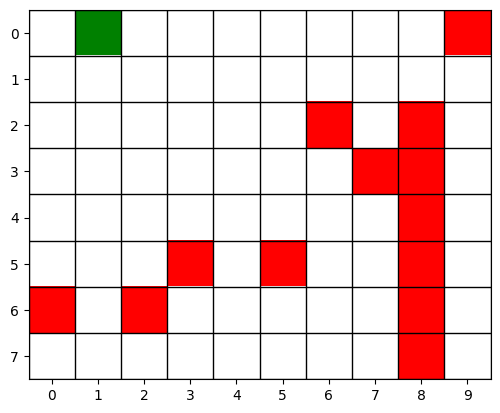

In [67]:
game.update_maze("R")
game.show_maze()

In [68]:
class Agent:
    def __init__(self, states, alpha=0.15, random_factor=0.2):
        self.state_history = [[(0,0),0]]
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_rewards(states)
        
    def init_rewards(self, states):
        #Initialize random state table 
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(i,j)] = np.random.uniform(high=max(special_points.values()), low=0.1)

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))
    
    def learn(self):
        target = 0                                                          # we know the "ideal" reward
        a = self.alpha
        for state, reward in reversed(self.state_history):
            self.G[state] = self.G[state]+ a * (target - self.G[state])
        self.state_history = []                                             # reset the state_history
        self.random_factor -= 10e-5                                         # decrease random_factor

    def choose_action(self, state, allowed_moves):
        next_move = None
        if np.random.random() < self.random_factor:
            next_move = np.random.choice(allowed_moves)
        else:
            maxG = -10e15                                                   # some really small random number
            for action in allowed_moves:
                new_state = tuple([sum(x) for x in zip(state, allowed_actions[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move

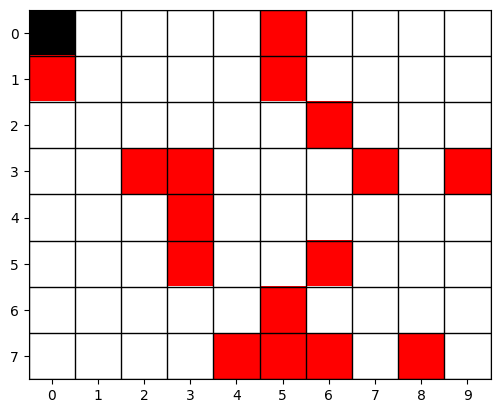

In [69]:
X, Y = 8, 10
special_points = {0:1,1:100}
results = {}
maze = generate_maze(X,Y,list(special_points.keys()),[0.8,0.2])
maze = Maze(maze, special_points)
robot = Agent(maze.maze, alpha=0.1, random_factor=0.25)
maze.show_maze()

In [70]:
steps = game.print_allowed_steps()

|-----------------------------
|-Position: 0,0
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|-Position: 0,1
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,2
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,3
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,4
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,5
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,6
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,7
|   |- D -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 0,8
|   |- D -> Cost: 1
|   |- R -> Cost: 100
|   |- L -> Cost: 1
|-Position: 0,9
|   |- D -> Cost: 1
|   |- L -> Cost: 1
|-Position: 1,0
|   |- D -> Cost: 1
|   |- U -> Cost: 1
|   |- R -> Cost: 1
|-Position: 1,1
|   |- D -> Cost: 1
|   |- U -> Cost: 1
|   |- R -> Cost: 1
|   |- L -> Cost: 1
|-Position: 1,2
|   |- D -> Cost: 1
|   |- U -> Cost: 1
|   |- R -> Cost: 1

In [71]:
epoches = 1000
for i in range(epoches):
    print('-'*50)
    t = time()
    while not maze.check_game_over():    
        state = maze.robot_position
        #print(state)        
        action = robot.choose_action(state, maze.allowed_steps[state])     # choose an action (explore or exploit)
        state, reward = maze.update_maze(action)                                            # update the maze according to the action
        robot.update_state_history(state, reward)                           # update the robot memory with state and reward
        if len(maze.steps) > 1000:
            maze.robot_position = (maze.Y, maze.X)
            
    robot.learn()                                                           # robot should learn after every episode
    score, steps_taken = maze.return_results_and_reset()
    results[score] = steps_taken
    print(f'Epoche {i} | Score: {score} | Steps: {len(steps_taken)} | Time {np.round(time()-t,4)}')

--------------------------------------------------
Epoche 0 | Score: 21989 | Steps: 1001 | Time -0.012154579162597656
--------------------------------------------------
Epoche 1 | Score: 17284 | Steps: 850 | Time -0.007562398910522461
--------------------------------------------------
Epoche 2 | Score: 7897 | Steps: 274 | Time -0.0015037059783935547
--------------------------------------------------
Epoche 3 | Score: 19811 | Steps: 1001 | Time -0.007005214691162109
--------------------------------------------------
Epoche 4 | Score: 18128 | Steps: 1001 | Time -0.008021831512451172
--------------------------------------------------
Epoche 5 | Score: 2156 | Steps: 176 | Time -0.0014507770538330078
--------------------------------------------------
Epoche 6 | Score: 7920 | Steps: 594 | Time -0.005095720291137695
--------------------------------------------------
Epoche 7 | Score: 739 | Steps: 46 | Time 0.0
--------------------------------------------------
Epoche 8 | Score: 10372 | Steps: